# Monthly hotel‑room occupancy — raw exploration
We have three parallel series (high‑tariff A, high‑tariff B, medium‑tariff).
All rates are percentages, so we convert them to proportions (`0 … 1`).


,Year-Month,Hotel room occupancy rate of high tariff A hotels,Hotel room occupancy rate of high tariff B hotels,Hotel room occupancy rate of medium tariff hotels,ds
0,202002,0.14,0.26,0.41,2020-02-01
1,202003,0.12,0.30,0.47,2020-03-01
2,202004,0.12,0.32,0.50,2020-04-01
3,202005,0.14,0.35,0.54,2020-05-01
4,202006,0.19,0.42,0.62,2020-06-01


/tmp/ipykernel_663103/3183358525.py:55: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Liberation Sans.
  ax.legend(frameon=False); fig.tight_layout()
/home/halsted/anaconda3/envs/murphet2/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Liberation Sans.
  func(*args, **kwargs)
/home/halsted/anaconda3/envs/murphet2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


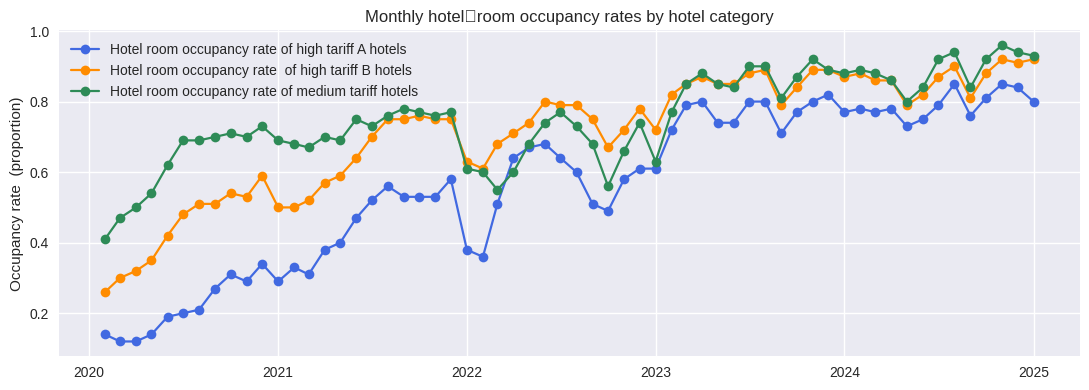

In [61]:
# %% [parameters] ────────────────────────────────────────────────────────────
"""
Configuration
-------------
Nothing else in the notebook should need editing – just keep these paths / names
up‑to‑date if you move the file or rename columns in the source CSV.
"""
import pathlib, os

ROOT       = pathlib.Path(os.getcwd()).resolve().parent        # project root
DATA_FILE  = ROOT / "examples" / "data" / "hotel_room_occupancy_rate_monthly_by_cat_en.csv"

DATE_COL   = "Year-Month"            # YYYYMM integer / string
VALUE_COLS = [
    "Hotel room occupancy rate of high tariff A hotels",
    "Hotel room occupancy rate  of high tariff B hotels",
    "Hotel room occupancy rate of medium tariff hotels"
]

# %% ─────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- load & tidy ------------------------------------------------------
df = pd.read_csv(DATA_FILE)

# strip stray whitespace in *every* column name
df.columns = df.columns.str.strip()

# YYYYMM → pandas datetime (month‑start index)
df["ds"] = pd.to_datetime(df[DATE_COL].astype(str), format="%Y%m", errors="raise")

# convert % → proportion
for col in VALUE_COLS:
    df[col] = df[col] / 100.0

# ensure all values are in the open interval (0,1)
if not ((df[VALUE_COLS] > 0) & (df[VALUE_COLS] < 1)).all().all():
    raise ValueError("Some occupancy rates fall outside (0, 1) – check the raw data!")

df = df.sort_values("ds").reset_index(drop=True)
display(df.head())

# --------- quick visual sanity‑check ----------------------------------------
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(11, 4))

col_colors = ["royalblue", "darkorange", "seagreen"]
for c, col in zip(col_colors, VALUE_COLS):
    ax.plot(df["ds"], df[col], marker="o", lw=1.6, label=col.strip(), color=c)

ax.set_ylabel("Occupancy rate  (proportion)")
ax.set_title("Monthly hotel‑room occupancy rates by hotel category")
ax.legend(frameon=False); fig.tight_layout()


In [62]:
# %%  ─────────────────────────────────────────────────────────────
# Choose the “high‑tariff A” series and set up cross‑validation
# -----------------------------------------------------------------
TARGET_COL = "Hotel room occupancy rate of high tariff A hotels"

series = (
    df[["ds", TARGET_COL]].rename(columns={TARGET_COL: "y"})
      .assign(t = np.arange(len(df), dtype=float))
)

t_all, y_all = series["t"].to_numpy(), series["y"].to_numpy()

# --- rolling‑origin CV windows -----------------------------------
INIT_MONTHS   = 24           # first 1½ years = training
CV_HORIZON    = 12            # forecast 3 months ahead each fold
CV_STEP       = 9            # slide by 3 months
HOLD_OUT_MO   = 9            # keep last 6 months for a final test

first_test  = INIT_MONTHS
fold_starts = list(range(first_test,
                         len(series) - HOLD_OUT_MO - CV_HORIZON + 1,
                         CV_STEP))
print(f"{len(series)} rows  →  {len(fold_starts)} CV folds")

# --- Optuna settings ---------------------------------------------------------
SEED        = 42
TRIALS_MUR  = 30
TRIALS_PROP = 5


60 rows  →  2 CV folds


In [63]:
import numpy as np
rmse = lambda a, f: np.sqrt(np.mean((a - f) ** 2))


In [64]:
# %%  ─────────────────────────────────────────────────────────────
# Hyper‑parameter spaces, CV objective, Optuna search, hold‑out fit
# -----------------------------------------------------------------
import optuna, warnings, time
from prophet import Prophet
from murphet import fit_churn_model

# --- search spaces -----------------------------------------------------------
def mur_cfg(trial):
    periods, harms = [12.0], [trial.suggest_int("harm_year", 1, 4)]
    if trial.suggest_categorical("add_half", [0, 1]):
        periods.append(6.0)
        harms.append(trial.suggest_int("harm_half", 1, 3))

    return dict(
        periods           = periods,
        num_harmonics     = harms,
        n_changepoints    = trial.suggest_int("n_cp", 2, 12),
        delta_scale       = trial.suggest_float("delta_scale", 0.02, 0.8, log=True),
        gamma_scale       = trial.suggest_float("gamma_scale", 1.0, 10.0),
        season_scale      = trial.suggest_float("season_scale", 0.4, 2.5),
        # ρ prior is fixed inside the Stan file; beta_phi is learned there too
        likelihood        = "beta",
        inference         = "map",
        chains            = 2,
        iter              = 4000,
        warmup            = 0,
        seed              = SEED,
    )



# --- Prophet search space ------------------------------------------------
def prop_cfg(trial):
    return dict(
        # Prophet’s *built‑in* yearly — we expose only its Fourier order:
        yearly_fourier = trial.suggest_int("yearly_fourier", 3, 10),

        # changepoint & seasonality priors
        cp_scale  = trial.suggest_float("cp_scale", 0.01, 0.5, log=True),
        sea_scale = trial.suggest_float("sea_scale", 0.1, 10.0, log=True),
    )


# --- CV objective ------------------------------------------------------------
def cv_objective(build_cfg, is_murphet):
    def _obj(trial):
        cfg, errs = build_cfg(trial), []

        for idx in fold_starts:
            tr_end, te_end = idx, idx + CV_HORIZON
            try:
                if is_murphet:                                 # Murphet branch
                    m   = fit_churn_model(t=t_all[:tr_end],
                                          y=y_all[:tr_end],
                                          **cfg)
                    pred = m.predict(t_all[tr_end:te_end])

                else:                                          # Prophet branch
                    p = Prophet(
                            changepoint_prior_scale = cfg["cp_scale"],
                            seasonality_prior_scale = cfg["sea_scale"],
                            yearly_seasonality      = cfg["yearly_fourier"],   # <── one line!
                            weekly_seasonality      = False,
                            daily_seasonality       = False,
                    )

                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        p.fit(series.iloc[:tr_end][["ds", "y"]])

                    fut  = p.make_future_dataframe(
                                CV_HORIZON, freq="MS").iloc[-CV_HORIZON:]
                    pred = p.predict(fut)["yhat"].to_numpy()

                errs.append(rmse(y_all[tr_end:te_end], pred))

            except RuntimeError:              # e.g. Stan or fitting failure
                return 1e6

        return float(np.mean(errs))
    return _obj


In [65]:

# --- search Murphet ----------------------------------------------------------
mur_study = optuna.create_study(direction="minimize",
                                sampler=optuna.samplers.TPESampler(seed=SEED))
mur_study.optimize(cv_objective(mur_cfg, True),
                   n_trials=TRIALS_MUR, show_progress_bar=True)
best_mur = mur_cfg(mur_study.best_trial)

[I 2025-04-19 23:03:32,613] A new study created in memory with name: no-name-66eb0bf0-ab0e-44cc-bab5-02ea5fc4bb2b
  0%|          | 0/30 [00:00<?, ?it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 0. Best value: 0.260059:   0%|          | 0/30 [00:00<?, ?it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:32,628] Trial 0 finished with value: 0.26005877683605894 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.03556159383830237, 'gamma_scale': 2.403950683025824, 'season_scale': 0.5219755855532189}. Best is trial 0 with value: 0.26005877683605894.


23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.196607:   3%|▎         | 1/30 [00:00<00:02, 13.27it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:32,689] Trial 1 finished with value: 0.19660652948817947 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 1, 'n_cp': 12, 'delta_scale': 0.43117447730995384, 'gamma_scale': 2.9110519961044856, 'season_scale': 0.7818324311349114}. Best is trial 1 with value: 0.19660652948817947.


23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 1. Best value: 0.196607:   7%|▋         | 2/30 [00:00<00:01, 21.22it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 3. Best value: 0.175344:  13%|█▎        | 4/30 [00:00<00:00, 30.94it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:32,708] Trial 2 finished with value: 1000000.0 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 2, 'n_cp': 5, 'delta_scale': 0.19109751468217398, 'gamma_scale': 2.2554447458683766, 'season_scale': 1.0135037619239582}. Best is trial 1 with value: 0.19660652948817947.
[I 2025-04-19 23:03:32,743] Trial 3 finished with value: 0.17534410109118376 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 1, 'n_cp': 7, 'delta_scale': 0.17787449279672934, 'gamma_scale': 1.4180537144799796, 'season_scale': 1.6758441889930205}. Best is trial 3 with value: 0.17534410109118376.


23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  13%|█▎        | 4/30 [00:00<00:00, 30.94it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  17%|█▋        | 5/30 [00:00<00:00, 30.94it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:32,771] Trial 4 finished with value: 0.11052197751539508 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.06152328666462679, 'gamma_scale': 1.8790490260574548, 'season_scale': 1.8368893556755297}. Best is trial 4 with value: 0.11052197751539508.
[I 2025-04-19 23:03:32,789] Trial 5 finished with value: 0.12903538220893584 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 1, 'n_cp': 12, 'delta_scale': 0.05195305024387061, 'gamma_scale': 6.962700559185838, 'season_scale': 1.054593259787763}. Best is trial 4 with value: 0.11052197751539508.


23:03:32 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  20%|██        | 6/30 [00:00<00:00, 30.94it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  27%|██▋       | 8/30 [00:00<00:00, 33.83it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 4. Best value: 0.110522:  27%|██▋       | 8/30 [00:00<00:00, 33.83it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.11052

[I 2025-04-19 23:03:32,838] Trial 6 finished with value: 0.14866827933770116 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 12, 'delta_scale': 0.3490111324600883, 'gamma_scale': 9.455490474077703, 'season_scale': 2.2791374358980625}. Best is trial 4 with value: 0.11052197751539508.
[I 2025-04-19 23:03:32,853] Trial 7 finished with value: 0.12615078326300186 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 4, 'delta_scale': 0.023631257130122117, 'gamma_scale': 3.927972976869379, 'season_scale': 1.2162223083479122}. Best is trial 4 with value: 0.11052197751539508.
[I 2025-04-19 23:03:32,865] Trial 8 finished with value: 1000000.0 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 5, 'delta_scale': 0.1480681594456554, 'gamma_scale': 2.2683180247728636, 'season_scale': 2.0846136595834834}. Best is trial 4 with value: 0.11052197751539508.
[I 2025-04-19 23:03:32,878] Trial 9 finished with value: 0.2655572734153976 and parameters: {'harm_year': 1, 'add_half': 0, 'n_cp': 4

23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  33%|███▎      | 10/30 [00:00<00:00, 33.83it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  37%|███▋      | 11/30 [00:00<00:00, 33.83it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing
23:03:32 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:32,912] Trial 10 finished with value: 0.11702024780765498 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 9, 'delta_scale': 0.06796747685534651, 'gamma_scale': 5.106948164203384, 'season_scale': 1.5492624453518926}. Best is trial 4 with value: 0.11052197751539508.
[I 2025-04-19 23:03:32,943] Trial 11 finished with value: 0.11734468995600875 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 9, 'delta_scale': 0.07184906174918348, 'gamma_scale': 5.161101277794808, 'season_scale': 1.5248109544745287}. Best is trial 4 with value: 0.11052197751539508.


23:03:32 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  43%|████▎     | 13/30 [00:00<00:00, 37.31it/s]23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  43%|████▎     | 13/30 [00:00<00:00, 37.31it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:32,974] Trial 12 finished with value: 0.1107799157772198 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.08313731514398305, 'gamma_scale': 5.663432490978866, 'season_scale': 1.7713066363028485}. Best is trial 4 with value: 0.11052197751539508.
[I 2025-04-19 23:03:33,013] Trial 13 finished with value: 0.10834211048380005 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.09516981994075052, 'gamma_scale': 6.774030243803907, 'season_scale': 2.4916347166696147}. Best is trial 13 with value: 0.10834211048380005.


23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  47%|████▋     | 14/30 [00:00<00:00, 37.31it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:33,088] Trial 14 finished with value: 0.1543430334401616 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 2, 'n_cp': 10, 'delta_scale': 0.11950747255621348, 'gamma_scale': 6.9706578575078435, 'season_scale': 2.4935080421174947}. Best is trial 13 with value: 0.10834211048380005.


23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  50%|█████     | 15/30 [00:00<00:00, 37.31it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:33,159] Trial 15 finished with value: 0.2272024898211893 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.7883316536325532, 'gamma_scale': 7.03020539314854, 'season_scale': 2.0680539524540165}. Best is trial 13 with value: 0.10834211048380005.


23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  57%|█████▋    | 17/30 [00:00<00:00, 27.28it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 13. Best value: 0.108342:  57%|█████▋    | 17/30 [00:00<00:00, 27.28it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:33,188] Trial 16 finished with value: 0.16320752250817416 and parameters: {'harm_year': 3, 'add_half': 1, 'harm_half': 2, 'n_cp': 6, 'delta_scale': 0.040348439221669544, 'gamma_scale': 1.0299987749092168, 'season_scale': 2.368878434668648}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:03:33,219] Trial 17 finished with value: 1000000.0 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 3, 'n_cp': 2, 'delta_scale': 0.1042151246192406, 'gamma_scale': 3.878853162371987, 'season_scale': 2.0722208241720774}. Best is trial 13 with value: 0.10834211048380005.


23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 13. Best value: 0.108342:  60%|██████    | 18/30 [00:00<00:00, 27.28it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  63%|██████▎   | 19/30 [00:00<00:00, 27.28it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  70%|███████   | 21/30 [00:00<00:00, 26.81it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:33,295] Trial 18 finished with value: 1000000.0 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 11, 'delta_scale': 0.2440516331924473, 'gamma_scale': 8.13720566505805, 'season_scale': 1.3980842216677203}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:03:33,318] Trial 19 finished with value: 0.3023531079856371 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 2, 'n_cp': 8, 'delta_scale': 0.03434059205811948, 'gamma_scale': 5.985629149990219, 'season_scale': 2.2047649265143017}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:03:33,342] Trial 20 finished with value: 0.15421174390144668 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 2, 'n_cp': 8, 'delta_scale': 0.05249002304872556, 'gamma_scale': 4.210335727372638, 'season_scale': 1.791496597748658}. Best is trial 13 with value: 0.10834211048380005.


23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  70%|███████   | 21/30 [00:00<00:00, 26.81it/s]

[I 2025-04-19 23:03:33,387] Trial 21 finished with value: 0.1125495437011415 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.08879269520666615, 'gamma_scale': 6.029536508199374, 'season_scale': 1.9137931739642873}. Best is trial 13 with value: 0.10834211048380005.


23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  73%|███████▎  | 22/30 [00:00<00:00, 26.81it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  80%|████████  | 24/30 [00:00<00:00, 26.32it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:33,430] Trial 22 finished with value: 0.14363412812372078 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 11, 'delta_scale': 0.08263640871375569, 'gamma_scale': 8.016463217784707, 'season_scale': 1.3326940406191727}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:03:33,462] Trial 23 finished with value: 0.12283864350797097 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 9, 'delta_scale': 0.05507997245665436, 'gamma_scale': 4.805606389649002, 'season_scale': 1.6894532334070471}. Best is trial 13 with value: 0.10834211048380005.


23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  80%|████████  | 24/30 [00:00<00:00, 26.32it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  83%|████████▎ | 25/30 [00:00<00:00, 26.32it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:33,529] Trial 24 finished with value: 0.17776262763327066 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 3, 'n_cp': 11, 'delta_scale': 0.1216799410236142, 'gamma_scale': 5.71641343532595, 'season_scale': 2.4750135142173812}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:03:33,568] Trial 25 finished with value: 0.11142891399316776 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.09313517113565542, 'gamma_scale': 9.922818950595769, 'season_scale': 1.987801219809774}. Best is trial 13 with value: 0.10834211048380005.


23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  90%|█████████ | 27/30 [00:00<00:00, 24.54it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  90%|█████████ | 27/30 [00:01<00:00, 24.54it/s]

[I 2025-04-19 23:03:33,605] Trial 26 finished with value: 0.12222015071592696 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 3, 'n_cp': 7, 'delta_scale': 0.06279886643381019, 'gamma_scale': 6.462181664194474, 'season_scale': 1.7162743621180216}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:03:33,628] Trial 27 finished with value: 0.20117101724861136 and parameters: {'harm_year': 1, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.04124697959700988, 'gamma_scale': 3.1631506992315073, 'season_scale': 1.5551453416295424}. Best is trial 13 with value: 0.10834211048380005.


23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  93%|█████████▎| 28/30 [00:01<00:00, 24.54it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342: 100%|██████████| 30/30 [00:01<00:00, 26.33it/s]

[I 2025-04-19 23:03:33,732] Trial 28 finished with value: 0.14959536433497655 and parameters: {'harm_year': 3, 'add_half': 1, 'harm_half': 2, 'n_cp': 11, 'delta_scale': 0.264760843433342, 'gamma_scale': 4.489752028071885, 'season_scale': 2.2853367763283554}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:03:33,752] Trial 29 finished with value: 0.27232076819840484 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.03389884368979773, 'gamma_scale': 7.621761452011772, 'season_scale': 0.48221619291624374}. Best is trial 13 with value: 0.10834211048380005.


In [66]:

# --- search Prophet ----------------------------------------------------------
prop_study = optuna.create_study(direction="minimize",
                                 sampler=optuna.samplers.TPESampler(seed=SEED))
prop_study.optimize(cv_objective(prop_cfg, False),
                    n_trials=TRIALS_PROP, show_progress_bar=True)
best_prop = prop_cfg(prop_study.best_trial)

[I 2025-04-19 23:03:33,790] A new study created in memory with name: no-name-d4b3f239-3461-4cf5-8133-8bbc6722a7d9
  0%|          | 0/5 [00:00<?, ?it/s]23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing
23:03:33 - cmdstanpy - INFO - Chain [1] start processing
23:03:34 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 0. Best value: 0.169876:  20%|██        | 1/5 [00:00<00:00,  4.37it/s]23:03:34 - cmdstanpy - INFO - Chain [1] start processing
23:03:34 - cmdstanpy - INFO - Chain [1] done processing
23:03:34 - cmdstanpy - INFO - Chain [1] start processing
23:03:34 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.122215:  40%|████      | 2/5 [00:00<00:00,  4.85it/s]23:03:34 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:34,019] Trial 0 finished with value: 0.16987622596579313 and parameters: {'yearly_fourier': 5, 'cp_scale': 0.4123206532618726, 'sea_scale': 2.9106359131330697}. Best is trial 0 with value: 0.16987622596579313.
[I 2025-04-19 23:03:34,209] Trial 1 finished with value: 0.12221484378732392 and parameters: {'yearly_fourier': 7, 'cp_scale': 0.018410729205738687, 'sea_scale': 0.2051110418843398}. Best is trial 1 with value: 0.12221484378732392.


23:03:34 - cmdstanpy - INFO - Chain [1] done processing
23:03:34 - cmdstanpy - INFO - Chain [1] start processing
23:03:34 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.122215:  60%|██████    | 3/5 [00:00<00:00,  5.21it/s]23:03:34 - cmdstanpy - INFO - Chain [1] start processing
23:03:34 - cmdstanpy - INFO - Chain [1] done processing
23:03:34 - cmdstanpy - INFO - Chain [1] start processing
23:03:34 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.122215:  80%|████████  | 4/5 [00:00<00:00,  6.22it/s]23:03:34 - cmdstanpy - INFO - Chain [1] start processing
23:03:34 - cmdstanpy - INFO - Chain [1] done processing
23:03:34 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:03:34,384] Trial 2 finished with value: 0.14597482362597708 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.29621516588303487, 'sea_scale': 1.5930522616241019}. Best is trial 1 with value: 0.12221484378732392.
[I 2025-04-19 23:03:34,497] Trial 3 finished with value: 0.13680697153746085 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.01083858126934475, 'sea_scale': 8.706020878304859}. Best is trial 1 with value: 0.12221484378732392.


23:03:34 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.122215: 100%|██████████| 5/5 [00:00<00:00,  5.97it/s]

[I 2025-04-19 23:03:34,626] Trial 4 finished with value: 0.12301012094423597 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.022948683681130556, 'sea_scale': 0.23102018878452935}. Best is trial 1 with value: 0.12221484378732392.


23:04:42 - cmdstanpy - INFO - Chain [1] start processing
23:04:42 - cmdstanpy - INFO - Chain [1] done processing
23:04:42 - cmdstanpy - INFO - Chain [1] start processing
23:04:42 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_663103/2897530440.py:57: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Liberation Sans.
  fig.tight_layout()
/home/halsted/anaconda3/envs/murphet2/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Liberation Sans.
  func(*args, **kwargs)
/home/halsted/anaconda3/envs/murphet2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)



Hold‑out RMSE
Murphet‑β : 0.09083296802785572
Prophet   : 0.15780964953315277


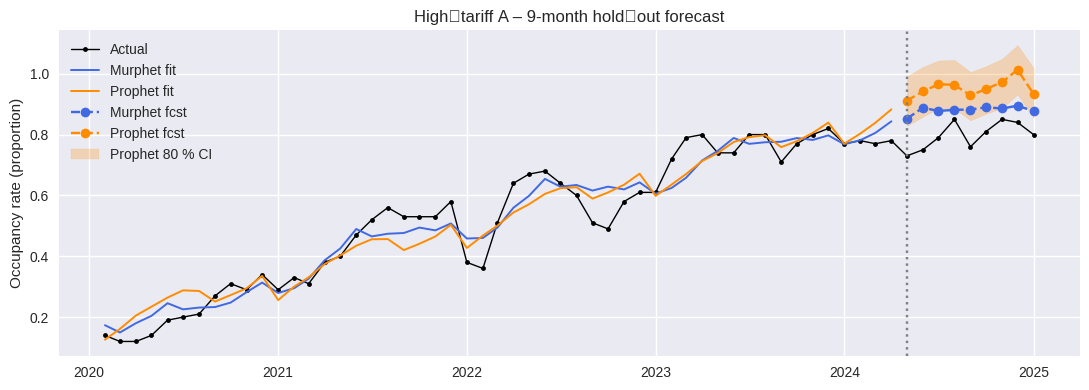

In [68]:
# --- final fit on training window ------------------------------------------
train, test = series.iloc[:-HOLD_OUT_MO], series.iloc[-HOLD_OUT_MO:]

# ─── Murphet‑β --------------------------------------------------------------
mur_fit  = fit_churn_model(t=train["t"], y=train["y"], **best_mur)
mur_pred = mur_fit.predict(test["t"])

# ─── Prophet  ---------------------------------------------------------------
prop_fit = Prophet(
    changepoint_prior_scale = best_prop["cp_scale"],
    seasonality_prior_scale = best_prop["sea_scale"],
    yearly_seasonality      = best_prop["yearly_fourier"],   # tuned Fourier order
    weekly_seasonality      = False,
    daily_seasonality       = False,
    interval_width          = 0.8,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    prop_fit.fit(train[["ds", "y"]])

future        = (prop_fit
                 .make_future_dataframe(HOLD_OUT_MO, freq="MS")
                 .iloc[-HOLD_OUT_MO:])
prop_df       = prop_fit.predict(future)
prop_pred     = prop_df["yhat"].to_numpy()
prop_low      = prop_df["yhat_lower"].to_numpy()
prop_upp      = prop_df["yhat_upper"].to_numpy()

# ─── simple numeric comparison ----------------------------------------------
print("\nHold‑out RMSE")
print("Murphet‑β :", rmse(test["y"], mur_pred))
print("Prophet   :", rmse(test["y"], prop_pred))

# ─── overlay plot ------------------------------------------------------------
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(11, 4))

ax.plot(series["ds"], series["y"], "k.-", lw=1, label="Actual")

ax.plot(train["ds"], mur_fit.predict(train["t"]),
        color="royalblue", lw=1.4, label="Murphet fit")
ax.plot(train["ds"],
        prop_fit.predict(train[["ds"]])["yhat"],
        color="darkorange", lw=1.4, label="Prophet fit")

ax.plot(test["ds"], mur_pred,  "o--", color="royalblue",  label="Murphet fcst")
ax.plot(test["ds"], prop_pred, "o--", color="darkorange", label="Prophet fcst")

ax.fill_between(test["ds"], prop_low, prop_upp,
                color="darkorange", alpha=0.25, label="Prophet 80 % CI")

ax.axvline(test["ds"].iloc[0], color="gray", ls="dotted")
ax.set_title(f"High‑tariff A – {HOLD_OUT_MO}-month hold‑out forecast")
ax.set_ylabel("Occupancy rate (proportion)")
ax.legend(frameon=False)
fig.tight_layout()
